<a href="https://colab.research.google.com/github/00150/AI_07_JYP_Project_section_02/blob/main/Used_car_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# 필요한 라이브러리를 설치합니다.
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
# 모델링을 진행할 데이터를 가져옵니다.
# 필요한 라이브러 및 패키지는 그때 그때 가져오도록 합니다.
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/00150/AI_07_JYP_Project_section_02/main/audi_eda').drop('Unnamed: 0', axis = 1)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9345 entries, 0 to 9344
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   model          9345 non-null   object 
 1   year           9345 non-null   int64  
 2   price          9345 non-null   int64  
 3   transmission   9345 non-null   object 
 4   mileage        9345 non-null   int64  
 5   fuelType       9345 non-null   object 
 6   tax            9345 non-null   int64  
 7   mpg            9345 non-null   float64
 8   engineSize     9345 non-null   float64
 9   size_and_type  9345 non-null   object 
 10  size           9345 non-null   object 
 11  type           9344 non-null   object 
 12  used_year      9345 non-null   int64  
 13  ampy           9345 non-null   float64
 14  km/l           9345 non-null   float64
dtypes: float64(4), int64(5), object(6)
memory usage: 1.1+ MB


앞서 EDA & Visualization 을 진행한 데이터에는 다음과 같은 컬럼이 존재합니다.

* 각각의 컬럼은 다음과 같습니다. 
  - model : 자동차의 모델명 
  - year : 연식 
  - price : 가격 
  - transmission : 변속기
  - mileage : 자동차 주행거리
  - fuelType : 자동차 연료의 유형
  - tax : 세금(자동차)
  - mpg(Miles per Gallon) : 자동차 연비(Fuel efficiency)
  - engineSize :엔진 크기
  - size_and_type :차량의 사이즈 및 타입
  - size : 차량의 사이즈
  - type : 차량의 유형
  - used_year : 차를 사용한 연도
  - ampy : 연간 평균 주행거리.
  - km/l : 자동차 연비(한국식 표현)

In [23]:
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,size_and_type,size,type,used_year,ampy,km/l
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4,small_hatchback,small,hatchback,6,2622.5,23.8
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0,subfull_sedan,subfull,sedan,7,5171.9,27.6
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4,small_hatchback,small,hatchback,7,4278.0,23.8
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0,mid_sedan,mid,sedan,6,4325.3,28.9
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0,submid_hatchback,submid,hatchback,4,499.5,21.3


##1. Feature Engineering
> 기존 데이터에서 추가로 이용할 수 있는 부분이 있다면 새로운 피처를 생성합니다.

 -  Good preference badge 추가하기. <br>
 차량을 사용한 이력이 3~5년사이, 주행거리가 30000이하, 자동차 연비(기준:km/l)가 21 이상이라면 뱃지를 달아줍니다.

 - 차량 모델에 상관없이 상태가 좋은 중고차를 구매하려고 하는 사람들이 분명 존재합니다. <br/>
   이들에게 추천해줄 수 있도록 분류하는 모델을 생성하고자 합니다.



In [24]:
# np.select() method를 이용합니다.
import numpy as np
conditionlist = [(df['used_year'] <=5) & (df['mileage'] <=30000) & (df['km/l'] >=21)]
select_data = ['good']

df['good_badge']  = np.select(conditionlist, select_data, default = 'Not Specified')

Not Specified    0.880257
good             0.119743
Name: good_badge, dtype: float64


<AxesSubplot:xlabel='good_badge', ylabel='count'>

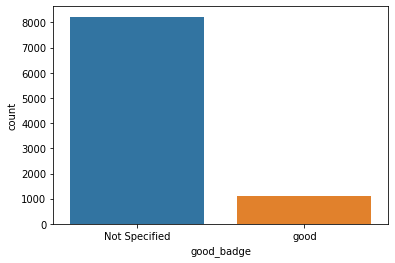

In [25]:
# 타겟 비율 확인
print(df['good_badge'].value_counts(normalize=True))

# 시각화 - 필요한 라이브러리 가져오기.
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x = df['good_badge'])

현재 타겟은 **불균형한 데이터 값**을 보여주고 있습니다.
* 모델 생성시 이 부분에 유의하여 모델을 생성하도록 합니다.

---

#2.  Model : `DecisionTree`

#### 2-1. Baseline 생성.
>기준모델로 최다 비율 클래스를 사용할 경우 정확도는 다음과 같습니다.

In [26]:
# 타겟값을 mapping 하도록 합니다.
# Not Specified = 0, good = 1
y_train = df['good_badge'].replace(['Not Specified', 'good'], [0,1])

# 기준 모델 생성 - 필요한 라이브러리 가져오기.
from sklearn.metrics import accuracy_score

major = y_train.mode()[0]


# 최다빈도 값 : 0이 담긴 리스트를 생성합니다. 
major = y_train.mode()[0]
y_pred = [major] * len(y_train)

# 기준모델의 정확도는 다음과 같습니다.
print(f'baseline accuracy:{accuracy_score(y_train, y_pred)}')

baseline accuracy:0.8802568218298555


####2-2. `ML : DecisionTreeClassifier` 생성.

In [27]:
# 데이터 분할.
from sklearn.model_selection import train_test_split

# 타겟 데이터를 같은 비율로 분할합니다.
train, val = train_test_split(df,
                                  train_size = 0.75,
                                  stratify = df['good_badge'],random_state = 42)


# target & feature 지정.00
target = 'good_badge'
features = df.columns.drop(['size_and_type','mpg',target])

# train
y_train = train[target]
X_train = train[features]

# val
y_val = val[target]
X_val = val[features]

# shap
print( X_train.shape, X_val.shape,'\n'*2)
print(y_train.value_counts(normalize=True),'\n'*2, y_val.value_counts(normalize=True),'\n'*2)

(7008, 13) (2337, 13) 


Not Specified    0.88028
good             0.11972
Name: good_badge, dtype: float64 

 Not Specified    0.880188
good             0.119812
Name: good_badge, dtype: float64 




In [28]:

# 데이터 인코딩 및 파이프라인 생성 : 필요한 라이브러리 가져오기.
from category_encoders import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

pipe = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(max_depth = 5, random_state=2))

print(pipe)

#eval_set
pipe.fit(X_train, 
          y_train)

print('검증 정확도:', pipe.score(X_val,y_val))

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, random_state=2))])
검증 정확도: 1.0


**검증 정확도가 1이 나왔습니다😥**
>모델을 시각화하여 과적합을 일으키는 컬럼을 확인합니다.

*`column: 'km/l'`을 지운 후 다시 한 번 살펴봅니다. 

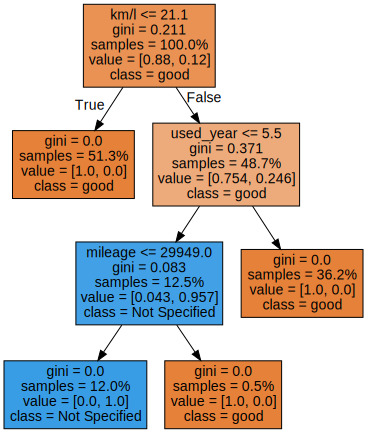

In [29]:
import graphviz
from sklearn.tree import export_graphviz

# 파이프라인에서 xgbclassifier에 접근.
tree = pipe.named_steps['decisiontreeclassifier']


dot_data = export_graphviz(
    tree,
    feature_names= X_train.columns,
    class_names = y_train.unique().astype(str),
    filled = True,
    proportion = True,
)

graphviz.Source(dot_data)

In [30]:
# 'km/l 제거'
features = df.columns.drop(['size_and_type','mpg','km/l',target])

# train
X_train = train[features]
y_train = train[target]

# val
X_val = val[features]
y_val = val[target]

# 새로운 파이프라인 생성.
pipe = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(max_depth = 5,
                           random_state = 42))


# fit
pipe.fit(X_train, y_train)
print(f'검증 정확도:{pipe.score(X_val, y_val)}')

검증 정확도:0.9490800171159607


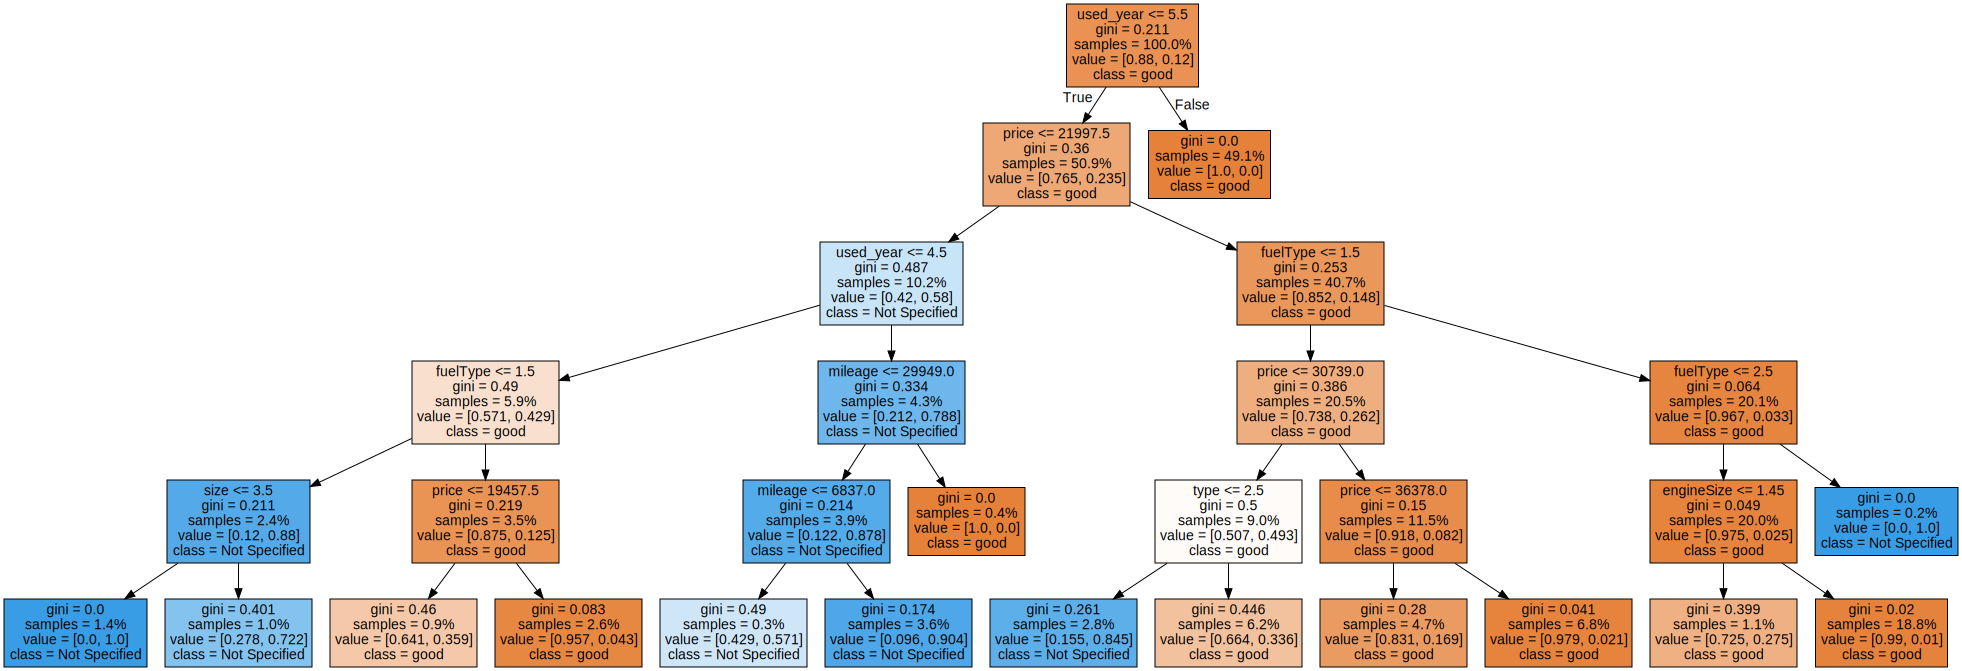

In [31]:
# 트리를 다시 한 번 시각화하여 봅시다.
tree = pipe.named_steps['decisiontreeclassifier']


dot_data = export_graphviz(
    tree,
    feature_names= X_train.columns,
    class_names = y_train.unique().astype(str),
    filled = True,
    proportion = True,
)

graphviz.Source(dot_data)

####2-3. Evaluation Mertircs : `DecisionTreeClassifier ` 
> 타겟 클래스 비용이 70% 이상 차이난다면 정확도만 사용하여 판단할 수 없습니다. (정확하지 않기 때문)

* 정밀도, 재현율, Roc-AUC등을 같이 사용하여 확인하여 봅시다.

**Confusion Matrix를 생성합니다.**

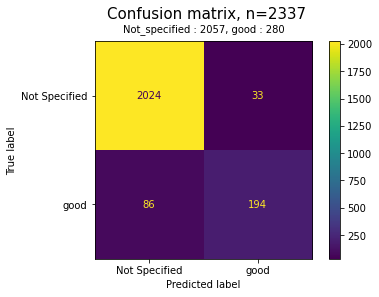

In [32]:
# 필요한 라이브러리를 가져옵니다.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 예측값 생성.
y_pred = pipe.predict(X_val)

# confusionmatrix 생성.
cm = confusion_matrix(y_val,
                      y_pred,
                      labels = pipe.named_steps['decisiontreeclassifier'].classes_)

# display
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = pipe.named_steps['decisiontreeclassifier'].classes_)

disp.plot()
plt.suptitle(f'Confusion matrix, n={len(y_val)}', fontsize = 15,y=1)
plt.title(f'Not_specified : {y_val.value_counts()[0]}, good : {y_val.value_counts()[1]}', fontsize =10, pad = 10)
plt.show()

**classification_report 또한 살펴봅니다**

In [33]:
# classification_report 생성.
from sklearn.metrics import classification_report
y_pred = pipe.predict(X_val)
print(classification_report(y_val,y_pred))

               precision    recall  f1-score   support

Not Specified       0.96      0.98      0.97      2057
         good       0.85      0.69      0.77       280

     accuracy                           0.95      2337
    macro avg       0.91      0.84      0.87      2337
 weighted avg       0.95      0.95      0.95      2337



In [34]:
pipe.predict_proba(X_val)[:,1]

array([0.        , 0.00984848, 0.        , ..., 0.        , 0.1686747 ,
       0.        ])

**ROC-AUC 커브를 시각화 및 Score 확인.**

In [35]:
# 필요한 라이브러리 가져오기.
from sklearn.metrics import roc_curve, roc_auc_score

# 점수 및 시각화에 대한 함수 생성 : get_roc_score
def get_roc_auc(model, X_val_encoded, y_val):
  
  # 우리가 생성한 모델이 XGBClassifier 이라면...
  if isinstance(model, XGBClassifier):
    y_pred_proba = model.predict_proba(
        X_val_encoded, 
        iteration_range = (0, model.best_iteration))[:,1]
  
  # 다른 모델을 생성했다면...
  else :
    y_pred_proba = model.predict_proba(X_val_encoded)[:,1]
  

  # try ~ except 생성.
  try :
    print(f'ROC-AUC: {roc_auc_score(y_val,y_pred_proba)} \n')

    # ROC-AUC : baseline 생성
    baseline_fpr, baseline_tpr, _ = roc_curve(y_val, [0]*len(y_val))

    # ROC-AUC : modelline 생성(baseline과 비교할 모델 값.)
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

    # fpr, tpr, threshold를 살펴볼 수 있는 df 생성.
    tmp = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})

    # plot : baseline 생성.
    plt.plot(baseline_fpr, baseline_tpr, linestyle = '--', color = 'green', label='Baseline')
  
  except ValueError as ve :
    y_val_replaced = y_val.replace(('Not Specified', 'good'),(0,1))
    print('ValiueError 로 인하여 타겟값 맵핑을 완료하였습니다.\n Not Specified = 0, good = 1 \n') 
    print(f'ROC-AUC값을 다시 한 번 출력합니다 : {roc_auc_score(y_val,y_pred_proba)} \n')
    
    # ROC-AUC : baseline 생성
    baseline_fpr, baseline_tpr, _ = roc_curve(y_val_replaced, [0]*len(y_val))

    # ROC-AUC : modelline 생성(baseline과 비교할 모델 값.)
    fpr, tpr, thresholds = roc_curve(y_val_replaced, y_pred_proba)

    # fpr, tpr, threshold를 살펴볼 수 있는 df 생성.
    tmp = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})

    # plot : baseline 생성.
    plt.plot(baseline_fpr, baseline_tpr, linestyle = '--', color = 'green', label='Baseline')

  # plot :modelline
  plt.plot(fpr, tpr, color = 'blue', label = 'Model') 
  plt.scatter(fpr, tpr, color = 'red')
  plt.legend()
  plt.title('Roc Curve')
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.show()
  return tmp
  



In [36]:
pipe.named_steps['decisiontreeclassifier'].classes_

array(['Not Specified', 'good'], dtype=object)

ROC-AUC: 0.96832158483228 

ValiueError 로 인하여 타겟값 맵핑을 완료하였습니다.
 Not Specified = 0, good = 1 

ROC-AUC값을 다시 한 번 출력합니다 : 0.96832158483228 



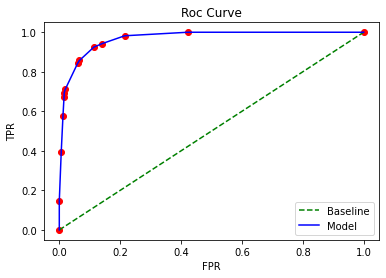

,fpr,tpr,thresholds
0,0.000000,0.000000,2.000000
1,0.000000,0.146429,1.000000
2,0.006320,0.392857,0.904000
3,0.012154,0.578571,0.845361
4,0.015557,0.671429,0.722222
5,0.016043,0.692857,0.571429
6,0.019446,0.710714,0.359375
7,0.060282,0.842857,0.335632
8,0.066116,0.857143,0.275000
9,0.113758,0.925000,0.168675


In [37]:
%matplotlib inline
get_roc_auc(pipe, X_val, y_val)

####2-4. DATA INSIGHT : `DecisionTreeClassifier`
* 타겟값이 불균형한 지표를 보여줬으나, 정확도는 매우 높은 값을 자랑하였습니다.
* classification report를 사용한 결과 최다빈도의 타겟 값은 잘 맞추지만, 적은 빈도 값의 재현율은 다소 낮았습니다.(70% 미만 확률) <br/>
* Roc - Curve가 직선과 비슷하게 나왔다면 분류가 잘 안된 것을 의미합니다.(회귀의 R2_score 처럼 나온 것이다.)<br/>

**주의❗)타겟 불균형이 존재할 때에는 AUC가 실제 성능에 비해 높게 계산됩니다.**<br/>

---



##3. Model : `XGBoost`
> Decision Tree 모델을 만들면서 현재 타겟값이 불균형한 클래스임을 알고 있습니다.

* 불균형 타겟 상황에서 타겟의 비율을 맞춰주기 위해 여러 기법을 사용하여 봅시다.


In [38]:
# 인코디을 진행할 인스턴스 객체를 생성합니다. : OrdinalEncoder
enc = OrdinalEncoder()

#--- applied data set(train, val)
X_train_encoded = enc.fit_transform(X_train)
X_val_encoded = enc.transform(X_val)


# created model
model = XGBClassifier(
    n_estimators =987654321,
    max_depth = 5,
    objective = 'binary:logistic',
    eval_metric = 'auc',
    learning_rate = 0.1,
    eary_stopping_rounds = 50,
    n_jobs = -1,
    random_state = 42
)